In [1]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.cross_validation import train_test_split
from models.cascade_base import CascadeBase
from utils.visualizer import Visualizer
from IPython.display import SVG, display

import numpy as np
import matplotlib.pyplot as plt

import time
import pydot
import lasagne

plt.style.use('ggplot')

%matplotlib inline

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [3]:
def get_hex_color(layer_type):
    """
    Determines the hex color for a layer.
    :parameters:
        - layer_type : string
            Class name of the layer
    :returns:
        - color : string containing a hex color for filling block.
    """
    COLORS = ['#4A88B3', '#98C1DE', '#6CA2C8', '#3173A2', '#17649B',
              '#FFBB60', '#FFDAA9', '#FFC981', '#FCAC41', '#F29416',
              '#C54AAA', '#E698D4', '#D56CBE', '#B72F99', '#B0108D',
              '#75DF54', '#B3F1A0', '#91E875', '#5DD637', '#3FCD12']

    hashed = int(hash(layer_type)) % 5

    if "conv" in layer_type.lower():
        return COLORS[:5][hashed]
    if layer_type in lasagne.layers.pool.__all__:
        return COLORS[5:10][hashed]
    if layer_type in lasagne.layers.recurrent.__all__:
        return COLORS[10:15][hashed]
    else:
        return COLORS[15:20][hashed]

def make_pydot_graph(layers, output_shape=True, verbose=False):
    """
    :parameters:
        - layers : list
            List of the layers, as obtained from lasagne.layers.get_all_layers
        - output_shape: (default `True`)
            If `True`, the output shape of each layer will be displayed.
        - verbose: (default `False`)
            If `True`, layer attributes like filter shape, stride, etc.
            will be displayed.
    :returns:
        - pydot_graph : PyDot object containing the graph
    """

    pydot_graph = pydot.Dot('Network', graph_type='digraph')
    pydot_nodes = {}
    pydot_edges = []
    for i, layer in enumerate(layers):
        layer_type = '{0}'.format(layer.__class__.__name__)
        layer_name = layer.name if layer.name is not None else ''
        key = repr(layer)
        label = layer_name + ' ' + layer_type
        color = get_hex_color(layer_type)
        if verbose:
            for attr in ['num_filters', 'num_units', 'ds',
                         'filter_shape', 'stride', 'strides', 'p']:
                if hasattr(layer, attr):
                    label += '\n{0}: {1}'.format(attr, getattr(layer, attr))
            if hasattr(layer, 'nonlinearity'):
                try:
                    nonlinearity = layer.nonlinearity.__name__
                except AttributeError:
                    nonlinearity = layer.nonlinearity.__class__.__name__
                label += '\nnonlinearity: {0}'.format(nonlinearity)

        if output_shape:
            label += '\nOutput shape: {0}'.format(layer.output_shape)

        pydot_nodes[key] = pydot.Node(
            key, label=label, shape='record', fillcolor=color, style='filled')

        if hasattr(layer, 'input_layers'):
            for input_layer in layer.input_layers:
                pydot_edges.append([repr(input_layer), key])

        if hasattr(layer, 'input_layer'):
            pydot_edges.append([repr(layer.input_layer), key])

    for node in pydot_nodes.values():
        pydot_graph.add_node(node)

    for edges in pydot_edges:
        pydot_graph.add_edge(
            pydot.Edge(pydot_nodes[edges[0]], pydot_nodes[edges[1]]))
    return pydot_graph

def iterate_minibatches(inputs, targets, batch_size):
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]

        yield inputs[excerpt], targets[excerpt]


def learn(nn,
          dataset,
          watches=['obj',
                   'recall',
                   'precision',
                   'accuracy',
                   'loss',
                   'sub_loss'],
          num_epochs=100,
          batch_size=50):
    '''
        num_epochs - amount of passes through the data
        batch_size - number of samples processed at each function call
        dataset - [X_train, X_val, y_train, y_val]
    '''
    %matplotlib notebook
    
    X_train, X_val, y_train, y_val = dataset
    metrics_template = dict()
    
    metrics_sample = nn.evaluate(X_val[:2], y_val[:2])
    
    for metric_name, _ in metrics_sample.items():
        if metric_name == 'complexity_parts':
            metrics_template[metric_name] = [0] * len(metrics_sample[metric_name])
        else:
            metrics_template[metric_name] = 0
        
    visualizer = Visualizer(num_epochs,
                            metrics_template,
                            watches=watches)
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        
        train_measurements = dict(metrics_template)
        train_batches = 0

        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.train(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        train_measurements[metric_name][j] += metric[j]
                else: 
                    train_measurements[metric_name] += metric

            train_batches += 1
            
        for metric_name, metric in train_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    train_measurements[metric_name][j] = metric[j] / train_batches
            else: 
                train_measurements[metric_name] = metric / train_batches

        # And a full pass over the validation data:
        val_measurements = dict(metrics_template)
        val_batches = 0

        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.evaluate(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        val_measurements[metric_name][j] += metric[j]
                else: 
                    val_measurements[metric_name] += metric

            val_batches += 1
            
        for metric_name, metric in val_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    val_measurements[metric_name][j] = metric[j] / val_batches
            else: 
                val_measurements[metric_name] = metric / val_batches

        print('Epoch {} of {} took {:.3f}s'.format(epoch + 1, num_epochs, time.time() - start_time))
        visualizer.watch(train_measurements, val_measurements)
    visualizer.finish()
    
def draw(network):
    with open('../images/net.svg', 'w') as f:
        g = make_pydot_graph(lasagne.layers.get_all_layers(network))
        f.write(g.create_svg(f='svg'))

    display(SVG(filename='../images/net.svg'))

In [4]:
dataset0 = np.load('../data/clean_artificial/imgs_0004.npy').reshape(-1, 1, 512, 512).astype(np.float32)
targets0 = np.load('../data/clean_artificial/masks_0004.npy').reshape(-1, 1, 512, 512).astype(np.float32)
dataset1 = np.load('../data/clean_artificial/imgs_0009.npy').reshape(-1, 1, 512, 512).astype(np.float32)
targets1 = np.load('../data/clean_artificial/masks_0009.npy').reshape(-1, 1, 512, 512).astype(np.float32)

dataset = np.vstack((dataset0, dataset1))
targets = np.vstack((targets0, targets1))

track_targets = targets.copy()
track_targets[track_targets <=0] = 0

In [5]:
X_y = train_test_split(dataset, track_targets)

## Train the network

In [17]:
network = CascadeBase(img_shape=(512, 512),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=1e-3,
                      c_sub_objs=[1e-4, 1e-3, 1e-2, 1e-1],
                      c_sub_obj_cs=[1e-1, 1e-1, 1e-1, 1e-1],
                      mul=True,
                      pool_sizes=[2, 2, 2, 2],
                      num_filters=[1, 1, 3, 6],
                      filter_sizes=[1, 3, 3, 3],
                      l2_c=1e-4)

In [ ]:
network.load('../weights', '3cascades_difficult_clear')

<IPython.core.display.Javascript object>


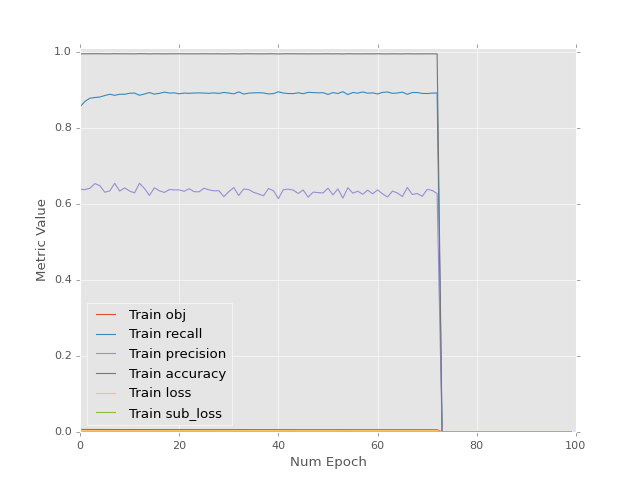

<IPython.core.display.Javascript object>


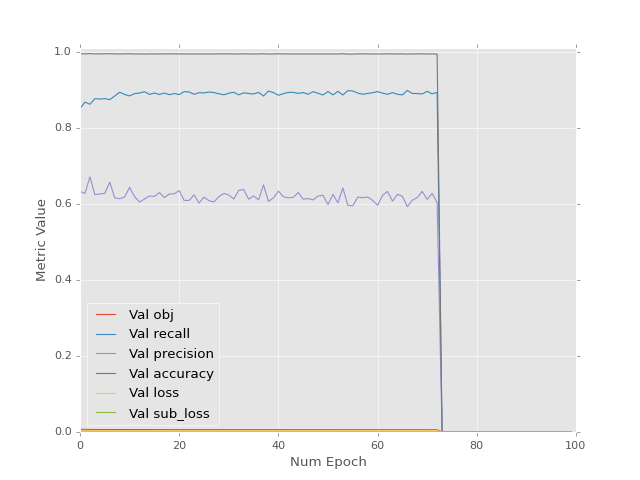

<IPython.core.display.Javascript object>


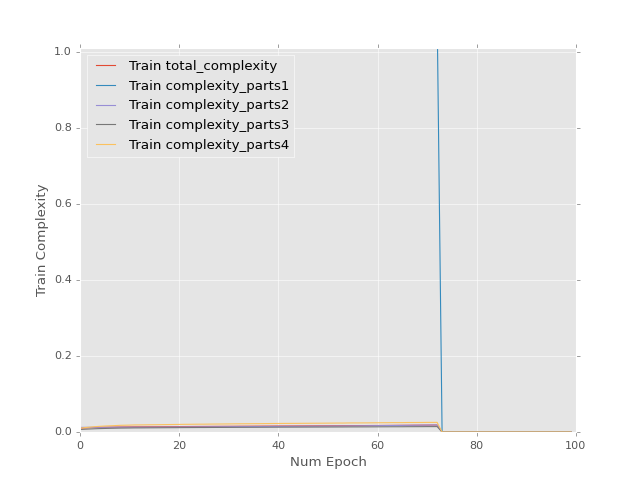

<IPython.core.display.Javascript object>


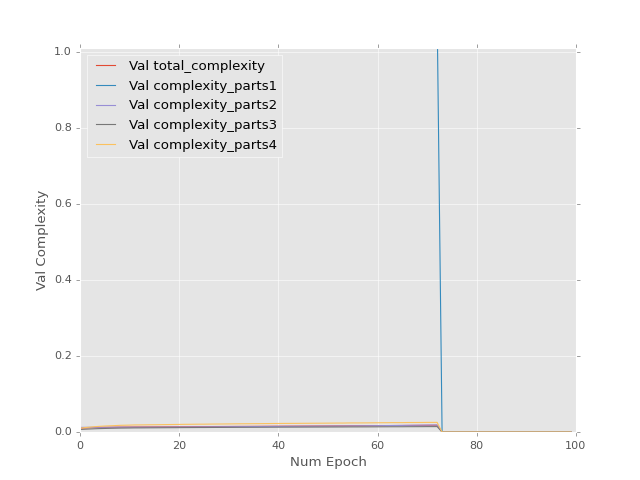

Epoch 1 of 100 took 61.240s
Epoch 2 of 100 took 61.915s
Epoch 3 of 100 took 61.978s
Epoch 4 of 100 took 62.171s
Epoch 5 of 100 took 62.467s
Epoch 6 of 100 took 62.322s
Epoch 7 of 100 took 62.485s
Epoch 8 of 100 took 62.128s
Epoch 9 of 100 took 61.818s
Epoch 10 of 100 took 62.822s
Epoch 11 of 100 took 61.227s
Epoch 12 of 100 took 61.325s
Epoch 13 of 100 took 61.212s
Epoch 14 of 100 took 61.060s
Epoch 15 of 100 took 61.006s
Epoch 16 of 100 took 61.443s
Epoch 17 of 100 took 60.841s
Epoch 18 of 100 took 61.281s
Epoch 19 of 100 took 60.779s
Epoch 20 of 100 took 60.673s
Epoch 21 of 100 took 60.196s
Epoch 22 of 100 took 60.321s
Epoch 23 of 100 took 61.651s
Epoch 24 of 100 took 62.541s
Epoch 25 of 100 took 61.514s
Epoch 26 of 100 took 61.493s
Epoch 27 of 100 took 61.564s
Epoch 28 of 100 took 61.585s
Epoch 29 of 100 took 61.558s
Epoch 30 of 100 took 87.355s
Epoch 31 of 100 took 61.765s
Epoch 32 of 100 took 62.096s
Epoch 33 of 100 took 61.753s
Epoch 34 of 100 took 61.963s
Epoch 35 of 100 took 62

In [ ]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=100,
      batch_size=50)

## Adjust Coefficients and add more data

In [7]:
X_y = train_test_split(dataset, track_targets)

In [8]:
network = CascadeBase(img_shape=(512, 512),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=3e-1,
                      c_sub_objs=[5e-2, 5e-2, 1, 1],
                      c_sub_obj_cs=[1e-2, 5e-2, 1e-1, 1e-1],
                      mul=True,
                      pool_sizes=[2, 2, 2, 2],
                      num_filters=[1, 1, 3, 6],
                      filter_sizes=[1, 3, 3, 3],
                      l2_c=1e-4)

INFO (theano.gof.compilelock): Waiting for existing lock by process '2489' (I am process '2509')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/apanin/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-centos-7.2.1511-Core-x86_64-2.7.11-64/lock_dir


In [9]:
network.load('../weights', '3cascades_difficult_clear')

/home/apanin/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


<IPython.core.display.Javascript object>


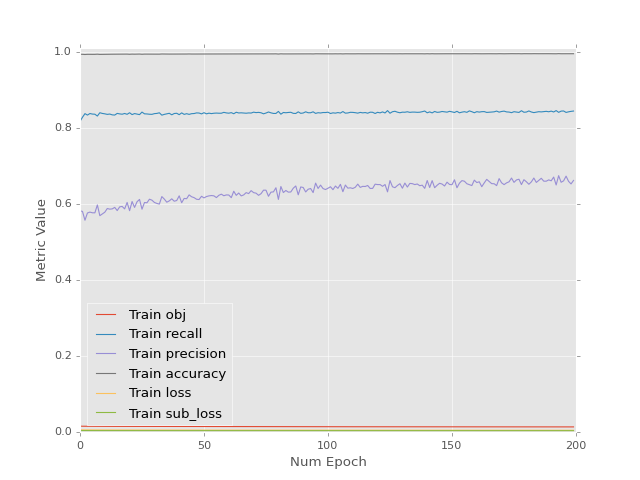

<IPython.core.display.Javascript object>


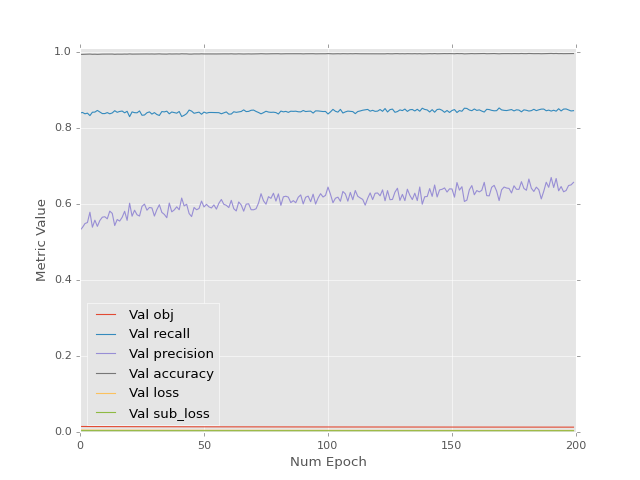

<IPython.core.display.Javascript object>


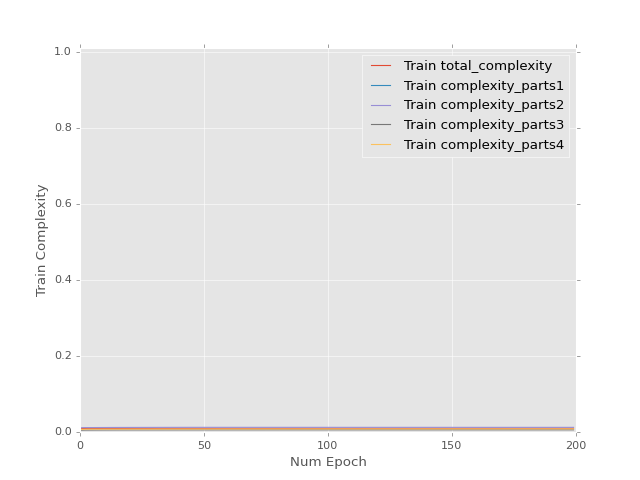

<IPython.core.display.Javascript object>


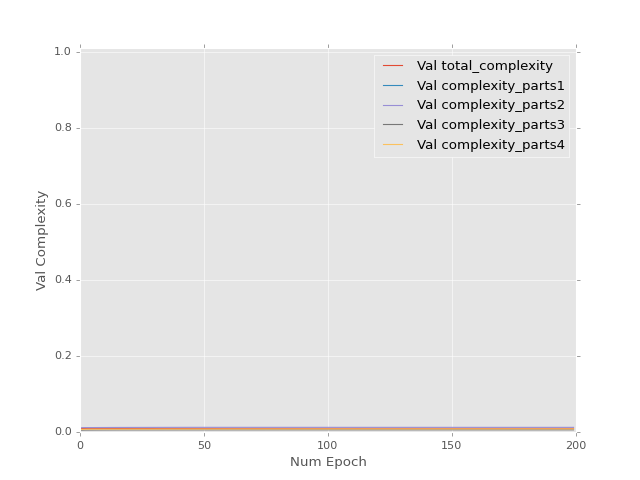

Epoch 1 of 200 took 61.309s


/home/apanin/anaconda/lib/python2.7/site-packages/matplotlib/backends/backend_webagg_core.py:210: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  buff.shape = (renderer.height, renderer.width)


Epoch 2 of 200 took 62.713s
Epoch 3 of 200 took 61.394s
Epoch 4 of 200 took 61.323s
Epoch 5 of 200 took 61.328s
Epoch 6 of 200 took 60.649s
Epoch 7 of 200 took 61.068s
Epoch 8 of 200 took 61.314s
Epoch 9 of 200 took 61.145s
Epoch 10 of 200 took 61.285s
Epoch 11 of 200 took 61.444s
Epoch 12 of 200 took 61.183s
Epoch 13 of 200 took 61.255s
Epoch 14 of 200 took 61.270s
Epoch 15 of 200 took 61.466s
Epoch 16 of 200 took 61.361s
Epoch 17 of 200 took 60.950s
Epoch 18 of 200 took 61.180s
Epoch 19 of 200 took 61.303s
Epoch 20 of 200 took 61.644s
Epoch 21 of 200 took 60.980s
Epoch 22 of 200 took 61.007s
Epoch 23 of 200 took 61.214s
Epoch 24 of 200 took 61.212s
Epoch 25 of 200 took 61.184s
Epoch 26 of 200 took 61.324s
Epoch 27 of 200 took 61.309s
Epoch 28 of 200 took 61.336s
Epoch 29 of 200 took 61.319s
Epoch 30 of 200 took 61.454s
Epoch 31 of 200 took 61.065s
Epoch 32 of 200 took 60.947s
Epoch 33 of 200 took 61.541s
Epoch 34 of 200 took 61.337s
Epoch 35 of 200 took 61.278s
Epoch 36 of 200 took 6

In [10]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=200,
      batch_size=50)

In [30]:
network.save('../weights', '3cascades_difficult')

In [11]:
network.save('../weights', '3cascades_difficult_clear')

# Check results

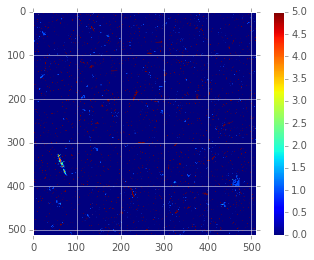

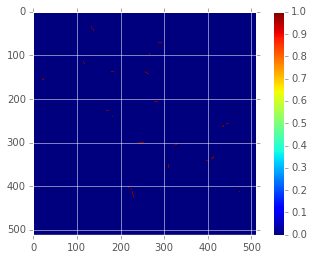

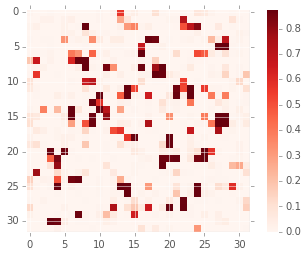

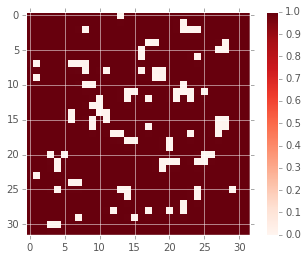

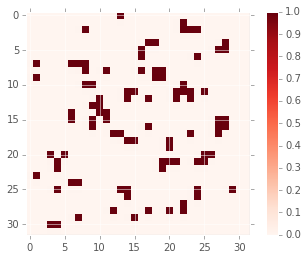

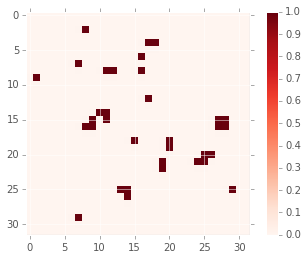

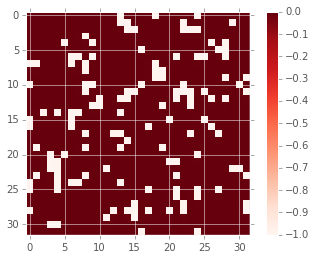

In [70]:
%matplotlib inline
i = np.random.choice(X_y[-1].shape[0])

plt.imshow(X_y[1][i][0])
plt.colorbar()
plt.show()

plt.imshow(X_y[-1][i][0], interpolation='none')
plt.colorbar()
plt.show()

prediction = network.predict(X_y[1][i:i + 1].astype(np.float32))

plt.imshow(prediction[0, 0], interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

plt.imshow(prediction[0, 0] < 0.5, interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

plt.imshow(prediction[0, 0] >= 0.5, interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

target = get_target(X_y[-1][i].reshape(1,1,512,512))[0, 0]
plt.imshow(target, interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

plt.imshow(target - (prediction[0, 0] > 0.071730167), interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

# Precision Vs Recall

In [32]:
import theano
get_target = theano.function([network.targets], lasagne.layers.get_output(network.target_pool_layers[-1]))

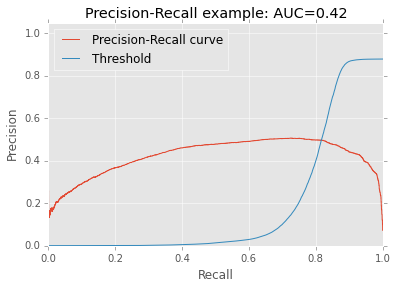

In [33]:
from sklearn.metrics import precision_recall_curve, average_precision_score

x_val = X_y[1][:100]
y_val = X_y[-1][:100]

prediction = network.predict(x_val)
target = get_target(y_val)

precision, recall, thr = precision_recall_curve(target.ravel(), prediction.ravel())
average_precision = average_precision_score(target.ravel(), prediction.ravel())

# Plot Precision-Recall curve
plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.plot(np.arange(thr.shape[0]) / (thr.shape[0] + 1e-6), thr, label='Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc='best')
plt.show()

In [68]:
precision[30000]

0.26052561008313219

In [69]:
thr[30000]

0.071730167

In [67]:
recall[30000]

0.99082100968893416